In [2]:
import pandas as pd
import nltk
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.callbacks import TensorBoard
import datetime

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Init Plugin
Init Graph Optimizer
Init Kernel


In [ ]:
nltk.download('averaged_perceptron_tagger')

In [3]:
def calculate_metrics(df):
    """
    Calculates the average sentence length, average grammatical complexity, and average sentiment
    score for each row of text in the input DataFrame.
    
    Parameters:
        df (Pandas DataFrame): A DataFrame with a single column of text
    
    Returns:
        Pandas DataFrame: A new DataFrame with the columns 'average_sentence_length', 'average_grammatical_complexity',
        and 'average_sentiment'
    """
    # Define a function to calculate the POS tag count for a given sentence
    def pos_tag_count(sentence):
        pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
        tag_count = len(pos_tags)
        return tag_count
    
    # Define a function to calculate the sentiment score for a given sentence
    def sentiment_score(sentence):
        blob = TextBlob(sentence)
        score = blob.sentiment.polarity
        return score
    
    # Tokenize the text into sentences
    sentences = df['prompt'].apply(nltk.sent_tokenize)
    
    # Calculate the average sentence length for each row
    df['average_sentence_length'] = sentences.apply(lambda x: sum(len(sentence.split()) for sentence in x)/len(x))
    
    # Calculate the average POS tag count for each row
    df['average_grammatical_complexity'] = sentences.apply(lambda x: sum(pos_tag_count(sentence) for sentence in x)/len(x))
    
    # Calculate the average sentiment score for each row
    df['average_sentiment'] = sentences.apply(lambda x: sum(sentiment_score(sentence) for sentence in x)/len(x))
    
    # Drop the 'sentences' column
    #df = df.drop('sentences', axis=1)
    
    return df[['average_sentence_length', 'average_grammatical_complexity', 'average_sentiment']]


In [4]:
df2 = pd.read_excel("3class.xlsx")
df2

,prompt,completion
0,"\n\nIn the late 1800s, a woman by the name of ...",10thgrade
1,\n\nThe Hunt for Enemy Technology - Early Jets...,10thgrade
2,The Division of Labour\n\nThe division of labo...,6thgrade
3,\n\n“Yes the body:” A Quarantined Review of Sp...,10thgrade
4,"\n\nOnce upon a time, in a world far different...",6thgrade
...,...,...
295,\n\nThe History of Silicon Valley — A Brief Su...,6thgrade
296,\n\nYes the Body: A Quarantined Review of Spaw...,6thgrade
297,"\n\nAs I stand atop the Eildon Hills, overlook...",college
298,"\n\nAs human beings, we have always been fasci...",10thgrade


In [5]:
# Calculate the metrics
metrics_df2 = calculate_metrics(df2)
df2

print(list(df2.columns))

['prompt', 'completion', 'average_sentence_length', 'average_grammatical_complexity', 'average_sentiment']


## all ai text model, 6th, 10th, college

In [6]:
# Load the data from the CSV file
# data = pd.read_csv("path/to/csv")
data = df2.copy()

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Encode the labels as integers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data["completion"])
test_labels = label_encoder.transform(test_data["completion"])

# Convert the data to numpy arrays
train_prompt = np.array(train_data["prompt"])
train_numerical = np.array(train_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])
test_prompt = np.array(test_data["prompt"])
test_numerical = np.array(test_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])


In [37]:
print(train_data['completion'])
for elem in train_labels:
    print(elem)

232     6thgrade
59     10thgrade
6        college
185     6thgrade
173     6thgrade
         ...    
188     6thgrade
71      6thgrade
106    10thgrade
270    10thgrade
102     6thgrade
Name: completion, Length: 240, dtype: object
1
0
2
1
1
0
1
2
1
2
0
2
0
0
0
2
1
1
2
1
1
2
0
0
2
2
2
1
0
1
0
1
1
1
2
2
2
1
0
2
0
2
2
2
1
2
2
1
1
2
2
2
1
1
1
1
0
1
1
0
0
0
0
1
2
1
2
0
1
0
0
1
0
0
0
1
2
1
0
1
0
0
2
0
1
1
2
1
0
2
1
0
0
0
2
1
0
1
2
2
2
2
2
0
2
2
1
0
0
1
2
1
2
0
1
1
2
0
1
2
0
0
2
1
0
2
2
0
2
1
0
2
2
0
1
0
1
2
0
0
1
2
0
0
2
1
2
1
2
2
0
2
0
0
0
1
0
1
2
1
0
2
1
2
1
2
2
2
1
2
2
0
0
0
2
0
0
2
0
1
2
0
1
0
0
0
0
2
2
0
1
2
0
0
2
2
2
2
1
1
1
1
1
1
0
2
2
0
2
1
1
2
0
1
0
2
2
0
1
0
2
1
0
2
0
2
0
0
1
0
1
2
1
2
1
1
1
0
0
1


In [7]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_prompt)
train_sequences = tokenizer.texts_to_sequences(train_prompt)
test_sequences = tokenizer.texts_to_sequences(test_prompt)

# Pad the sequences to be the same length
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")


In [69]:

# Define the inputs for the model
input_text = Input(shape=(max_length,))
input_numerical = Input(shape=(3,))

# Embed the text data
embedding = Embedding(input_dim=10000, output_dim=128)(input_text)
lstm1 = LSTM(64, kernel_regularizer=regularizers.l1(0.055))(embedding)
lstm2 = LSTM(16)(embedding)

# Combine the text
combined = Concatenate()([lstm1, input_numerical])

# Add some dropout for regularization
dropout = Dropout(0.2)(combined)

# Add a dense output layer
output = Dense(len(label_encoder.classes_), activation="softmax")(dropout)

# Define the model
model = Model(inputs=[input_text, input_numerical], outputs=output)


In [70]:
learning_rate = 0.001
batch_size = 132

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit([train_padded, train_numerical], train_labels, validation_data=([test_padded, test_numerical], test_labels), epochs=500, batch_size=batch_size, callbacks=[tensorboard_callback])


2023-04-29 19:39:27.828773: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-29 19:39:27.828785: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-29 19:39:27.828951: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/500


2023-04-29 19:39:28.756727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-29 19:39:29.006409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-29 19:39:29.708051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 2s - loss: 117.4991 - accuracy: 0.3409

2023-04-29 19:39:30.543808: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-29 19:39:30.543824: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


2/2 [==============================] - ETA: 0s - loss: 116.4786 - accuracy: 0.3708

2023-04-29 19:39:31.599722: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-04-29 19:39:31.600644: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-04-29 19:39:31.601542: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230429-193927/train/plugins/profile/2023_04_29_19_39_31
2023-04-29 19:39:31.602198: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20230429-193927/train/plugins/profile/2023_04_29_19_39_31/Aarons-MacBook-Pro.local.trace.json.gz
2023-04-29 19:39:31.603301: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230429-193927/train/plugins/profile/2023_04_29_19_39_31
2023-04-29 19:39:31.603570: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/20230429-193927/train/plugins/profile/2023_04_29_

2/2 [==============================] - 4s 2s/step - loss: 116.4786 - accuracy: 0.3708 - val_loss: 113.1450 - val_accuracy: 0.3000
Epoch 2/500
2/2 [==============================] - 0s 143ms/step - loss: 112.9385 - accuracy: 0.2958 - val_loss: 109.5524 - val_accuracy: 0.3000
Epoch 3/500
2/2 [==============================] - 0s 153ms/step - loss: 109.1197 - accuracy: 0.3417 - val_loss: 106.0248 - val_accuracy: 0.3000
Epoch 4/500
2/2 [==============================] - 0s 126ms/step - loss: 105.2571 - accuracy: 0.3792 - val_loss: 102.5576 - val_accuracy: 0.3000
Epoch 5/500
2/2 [==============================] - 0s 137ms/step - loss: 102.3723 - accuracy: 0.3625 - val_loss: 99.1478 - val_accuracy: 0.3000
Epoch 6/500
2/2 [==============================] - 0s 119ms/step - loss: 98.6746 - accuracy: 0.3833 - val_loss: 95.7629 - val_accuracy: 0.3000
Epoch 7/500
2/2 [==============================] - 0s 173ms/step - loss: 95.3890 - accuracy: 0.3500 - val_loss: 92.3607 - val_accuracy: 0.3000
Epoch

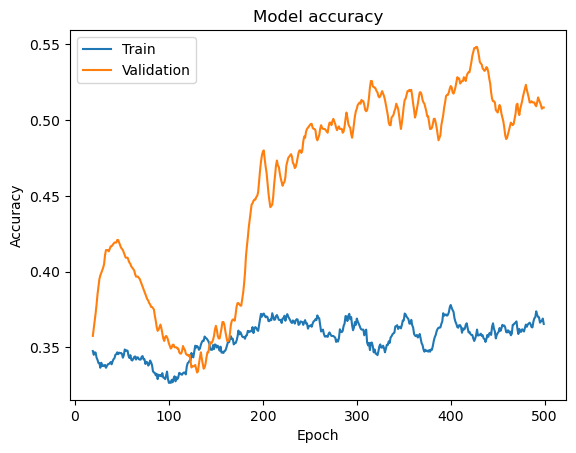

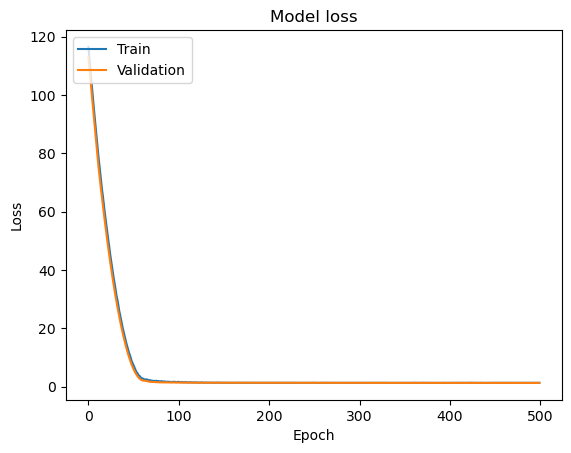

In [71]:
import matplotlib.pyplot as plt

import pandas as pd

# convert the accuracy data to a Pandas Series
train_acc = pd.Series(history.history["accuracy"])
val_acc = pd.Series(history.history["val_accuracy"])

# compute a rolling average with a window size of 10
window_size = 20
train_acc_smooth = train_acc.rolling(window_size).mean()
val_acc_smooth = val_acc.rolling(window_size).mean()

# plot the smoothed data
plt.plot(train_acc_smooth)
plt.plot(val_acc_smooth)
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()


# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [72]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the training set
train_pred = model.predict([train_padded, train_numerical])
train_pred_classes = np.argmax(train_pred, axis=1)

# Create the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred_classes)

print("Training confusion matrix:")
print(train_cm)

# Make predictions on the test set
test_pred = model.predict([test_padded, test_numerical])
test_pred_classes = np.argmax(test_pred, axis=1)

# Create the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred_classes)

print("Test confusion matrix:")
print(test_cm)


2023-04-29 19:43:12.111530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-29 19:43:12.190667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training confusion matrix:
[[25 24 32]
 [24 47  6]
 [30 15 37]]
Test confusion matrix:
[[ 6  7  6]
 [ 7 15  1]
 [ 7  1 10]]


In [ ]:
# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate([test_padded, test_numerical], test_labels)

# Print the testing accuracy
print("Test accuracy:", test_acc)


2/2 [==============================] - 0s 29ms/step - loss: 1.1928 - accuracy: 0.2500
Test accuracy: 0.25


Training confusion matrix:
[[25 24 32]
 [24 47  6]
 [30 15 37]]


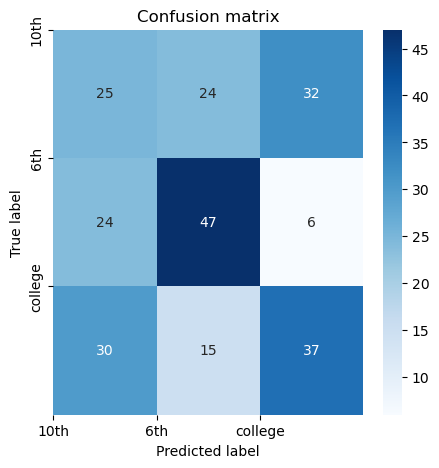

Test confusion matrix:
[[ 6  7  6]
 [ 7 15  1]
 [ 7  1 10]]


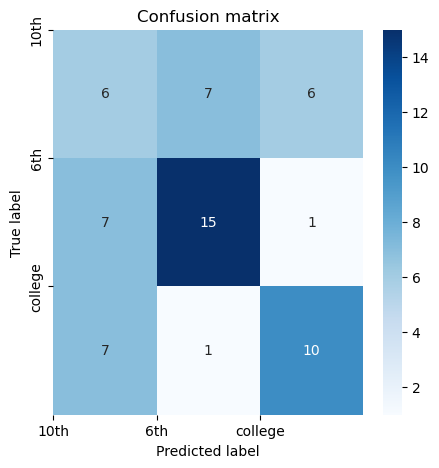

In [73]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ['10th', '6th', 'college']

# Define function to create and style confusion matrix
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)
    plt.show()


# Make predictions on the training set
train_pred = model.predict([train_padded, train_numerical])
train_pred_classes = np.argmax(train_pred, axis=1)

# Create the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred_classes)

print("Training confusion matrix:")
print(train_cm)

# Plot styled confusion matrix for training set
plot_confusion_matrix(train_cm, class_labels)

# Make predictions on the test set
test_pred = model.predict([test_padded, test_numerical])
test_pred_classes = np.argmax(test_pred, axis=1)

# Create the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred_classes)

print("Test confusion matrix:")
print(test_cm)

# Plot styled confusion matrix for test set
plot_confusion_matrix(test_cm, class_labels)


Training confusion matrix:
[[62  3 16]
 [42 33  2]
 [59  4 19]]


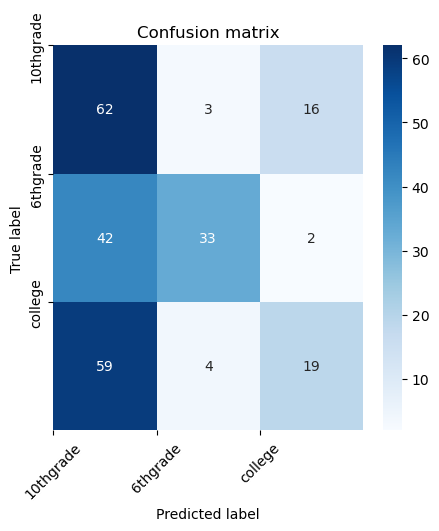

Test confusion matrix:
[[14  1  4]
 [13 10  0]
 [ 9  0  9]]


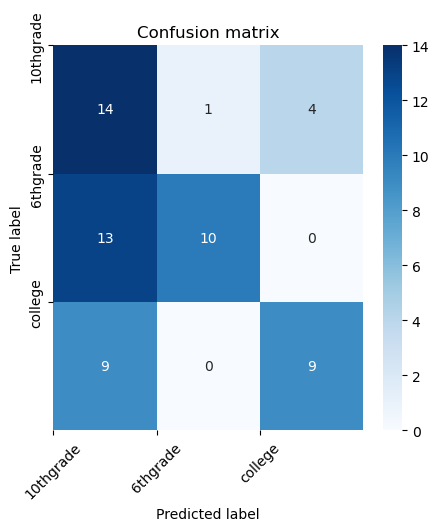

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to create and style confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.show()

# Get unique labels in your data
labels = np.unique(train_data['completion'])

# Make predictions on the training set
train_pred = model.predict([train_padded, train_numerical])
train_pred_classes = np.argmax(train_pred, axis=1)

# Create the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred_classes)

print("Training confusion matrix:")
print(train_cm)

# Plot styled confusion matrix for training set
plot_confusion_matrix(train_cm, labels)

# Make predictions on the test set
test_pred = model.predict([test_padded, test_numerical])
test_pred_classes = np.argmax(test_pred, axis=1)

# Create the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred_classes)

print("Test confusion matrix:")
print(test_cm)

# Plot styled confusion matrix for test set
plot_confusion_matrix(test_cm, labels)
